In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')
pd.set_option('display.max_colwidth', -1)

### Часть 1. Приоритизация гипотез.

In [2]:
hypothesis['ICE'] = (
    (hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'])
    .map(lambda i: '{:.2f}'.format(i))
    .astype('float')
)
hypothesis = hypothesis.sort_values(by='ICE', ascending=False)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


In [3]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis = hypothesis.sort_values(by='RICE', ascending=False)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Вычислили в столбцах значения ICE и RICE. Отличие при подсчете в метрике Reach (объем затронутых изменением пользователей). Если в расчете ICE итог почти коррелирует со значением Confidence (уверенность во влиянии на пользователей), то при расчете RICE объем затронутых пользователей меняет картину. И вот гипотезы с высоким Reach выходят на передний план. Значит уверенности в изменениях и их силы влияния не хватило, чтобы перекрыть значимость объема затрагиваемой клиентуры.

### Часть 2. Анализ A/B-теста

* Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [4]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

In [5]:
datesGroups = orders[['date', 'group']].drop_duplicates()

Создала датафрейм со столбцами 'date' и 'group' с удаленными дубликатами.

In [6]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date':'max', 'group':'max', 'transactionId': pd.Series.nunique, 'visitorId':pd.Series.nunique,'revenue':'sum'}), 
    axis=1).sort_values(['date', 'group'])

OrdersAggregated содержит дату; группу A/B-теста; число уникальных заказов в группе теста по указанную дату включительно; число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно; суммарную выручку заказов в группе теста по указанную дату включительно.

In [7]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1).sort_values(['date','group'])

VisitorsAggregated содержит дату; группу A/B-теста; количество уникальных посетителей в группе теста по указанную дату включительно.

In [8]:
cummulativeData = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


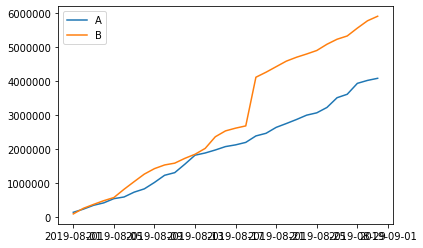

In [9]:
cummulativeRevenueA = cummulativeData[cummulativeData['group'] == 'A']
cummulativeRevenueB = cummulativeData[cummulativeData['group'] == 'B']
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'], label='B')
plt.legend()

С самого начала теста по кумулятивной выручке группа B вырвалась вперёд и продолжала лидировать весь остаток теста. Возможно на результаты повлияли неотфильтрованные по выбросам данные.

* Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

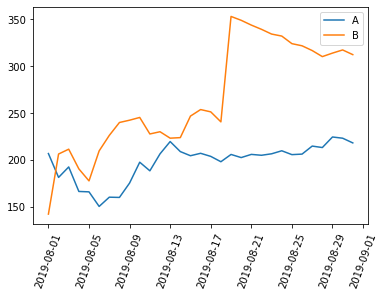

In [27]:
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'] / cummulativeRevenueA['visitors'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'] / cummulativeRevenueB['visitors'], label='B')
plt.legend()
ticks = plt.xticks(rotation=70)  #код наставника

Различие в среднем чеке между группами прыгает.

* Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

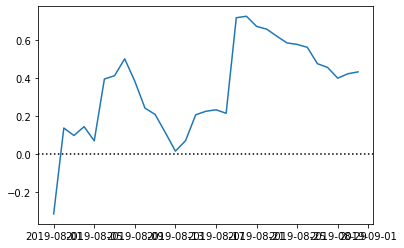

In [11]:
mergedCummulativeRevenue = cummulativeRevenueA.merge(cummulativeRevenueB, on='date', how='left', suffixes=['-A','-B'])
plt.plot(mergedCummulativeRevenue['date'], (mergedCummulativeRevenue['revenue-B']/mergedCummulativeRevenue['visitors-B'])/
        (mergedCummulativeRevenue['revenue-A']/mergedCummulativeRevenue['visitors-A'])-1)
plt.axhline(y=0, color='black', linestyle=':')

В графике относительного изменения кумулятивного среднего чека группы В к группе А резкие спады и взлеты сохраняются. Значит исходные данные прыгают, нужно проверить необходимость фильтрации.

* Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

['2019-08-01', '2019-08-31', 0, 0.05]

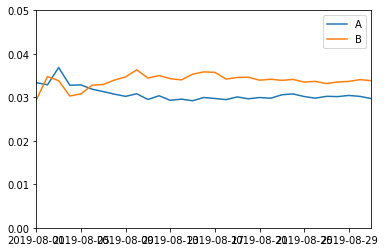

In [12]:
cummulativeData['conversion'] = cummulativeData['transactionId'] / cummulativeData['visitors']
cummulativeDataA = cummulativeData[cummulativeData['group'] == 'A']
cummulativeDataB = cummulativeData[cummulativeData['group'] == 'B']
plt.plot(cummulativeDataA['date'], cummulativeDataA['conversion'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['conversion'], label='B')
plt.legend()
plt.axis(["2019-08-01", '2019-08-31', 0, 0.05])

Конверсия группы В в начале месяца вырывается вперед и в конце теста опережает группу А на ~ 0.5 %.

* Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

['2019-08-01', '2019-08-31', -0.2, 0.3]

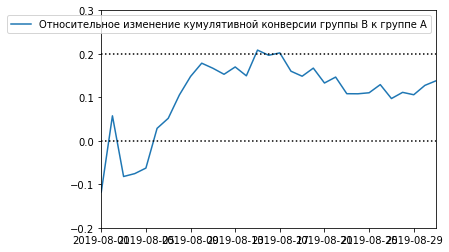

In [13]:
mergedCummulativeConversions = cummulativeDataA.merge(cummulativeDataB, on='date', how='left', suffixes=['-A', '-B'])
plt.plot(mergedCummulativeConversions['date'],
         (mergedCummulativeConversions['conversion-B']/mergedCummulativeConversions['conversion-A'])-1,
         label='Относительное изменение кумулятивной конверсии группы B к группе A')

plt.legend()
plt.axhline(y=0, color='black', linestyle=':')
plt.axhline(y=0.2, color='black', linestyle=':')
plt.axis(['2019-08-01', '2019-08-31', -0.2, 0.3])

Примерно с 3его дня теста группа B лидирует по конверсии и идет на спад с середины месяца.

* Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

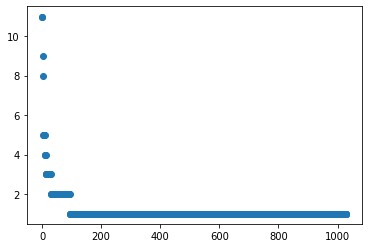

In [14]:
ordersByUsers = orders.groupby('visitorId', as_index=False)['transactionId'].agg({'transactionId':'nunique'}).sort_values(['transactionId'], ascending=False)
x_values = pd.Series(range(0, len(ordersByUsers['visitorId'])))
plt.scatter(x_values, ordersByUsers['transactionId'])

Большинство пользователей совершило 1 заказ.

* Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [15]:
np.percentile(ordersByUsers['transactionId'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершали больше двух заказов. И не более 1% пользователей — больше четырех заказов. Все, что идет больше, явно выбросы.

* Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

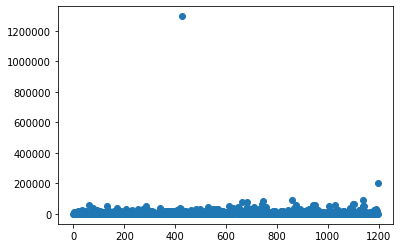

In [16]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
#plt.axis([0, 1200, 0, 50000])

Проведем примерный средний уровень стоимости заказов в 20 000 рублей. Пока считаем, что все, что больше - это выбросы.

* Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [17]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

В итоге у 5% заказов чек дороже 28 000 рублей. И у 1% заказов — дороже 58 000 рублей. Меняем границу выбросов

* Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.

In [18]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
                                            .agg({'date':'max', 'visitorsPerDateA':'sum'}), axis=1)
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
                                           .agg({'date':'max', 'visitorsPerDateB':'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

По таблице Visitors выделили группы А и В, ограничили двумя столбцами. На этой основе вывели столбец с кумулятивной суммой количества посетителей по каждой дате.

In [19]:
ordersADaily = orders[orders['group'] == 'A'][['transactionId', 'visitorId', 'date', 'revenue']]\
                .groupby('date', as_index=False)\
                .agg({'transactionId':'nunique', 'revenue':'sum'})
ordersBDaily = orders[orders['group'] == 'B'][['transactionId', 'visitorId', 'date', 'revenue']]\
                .groupby('date', as_index=False)\
                .agg({'transactionId':'nunique', 'revenue':'sum'})
ordersADaily.columns = ['date', 'transactionPerDateA', 'revenuePerDateA']
ordersBDaily.columns = ['date', 'transactionPerDateB', 'revenuePerDateB']
ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]
                                       .agg({'date':'max', 'transactionPerDateA':'sum', 'revenuePerDateA':'sum'}), axis=1)\
                                       .sort_values(['date'])
ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]
                                        .agg({'date':'max', 'transactionPerDateB':'sum', 'revenuePerDateB':'sum'}), axis=1)\
                                        .sort_values(['date'])
ordersACummulative.columns = ['date', 'transactionCummulativeA', 'revenueCummulativeA']
ordersBCummulative.columns = ['date', 'transactionCummulativeB', 'revenueCummulativeB']

По таблице Orders выделили группы А и В, оставили уникальные заказы и посчитали суму по ним. На этой основе вывели столбцы с кумулятивной суммой количества заказов и стоимости заказов по каждой дате.

In [20]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

Объединили все восемь новых таблиц в одну

In [21]:
ordersByUsersA = orders[orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsersB = orders[orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})

sampleA = pd.concat([ordersByUsersA['transactionId'], pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionId'])), name='transactionId')], axis=0)
sampleB = pd.concat([ordersByUsersB['transactionId'], pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionId'])), name='transactionId')], axis=0)

print('P-value в сравнении конверсии между группами: ', '{:.4f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('Относительное различие в конверсии между группами: ', '{:.3f}'.format((data['transactionPerDateB'].sum() / data['visitorsPerDateB'].sum()) / (data['transactionPerDateA'].sum() / data['visitorsPerDateA'].sum())-1))

P-value в сравнении конверсии между группами:  0.0084
Относительное различие в конверсии между группами:  0.138


P-value значительно меньше 0.05, потому нулевую гипотезу отвергаем. В конверсии между группами А и В есть значимые различия.
Относительный прирост конверсии группы В относительно группы А составил 13,8%.

* Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

In [22]:
print('P-value в сравнении средних чеков между группами: ', '{:.3f}'.format(st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]))
print('Относительный прирост среднего чека группы B: ', '{:.3f}'.format(orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean()-1))

P-value в сравнении средних чеков между группами:  0.365
Относительный прирост среднего чека группы B:  0.259


P-value больше 0.05, значит нулевая гипотез подтверждена: статистически значимых отличий в среднем чеке между группами нет. Относительный прирост среднего чека группы В относительно группы А составил 25,9%.

* Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.

In [23]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['transactionId'] > 2]['visitorId'], ordersByUsersB[ordersByUsersB['transactionId'] > 2]['visitorId']], axis=0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['transactionId'], pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionId'])), name='transactionId')], axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['transactionId'], pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionId'])), name='transactionId')], axis=0)

print('p-value в сравнении конверсии между очищенными группами: ', '{:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное различие в конверсии между очищенными группами: ', '{:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value в сравнении конверсии между очищенными группами:  0.00652
Относительное различие в конверсии между очищенными группами:  0.173


И по чистым данным статистическая разница между конверсией в группах А и В выявлена. Также относительная разница в конверсии между группами возросла до 17,3%.

* Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [24]:
print('p-value в сравнении средних чеков между очищенными группами: ', '{:.3f}'.format(st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('Относительный прирост среднего чека очищенной группы B: ', '{:.3f}'.format(orders[np.logical_and(orders['group'] == 'B',
               np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A',
               np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()-1))

p-value в сравнении средних чеков между очищенными группами:  0.369
Относительный прирост среднего чека очищенной группы B:  -0.020


В очищенных данных не появилось значимых различий в среднем чеке между группами. Однако относительный прирост среднего чека в группе В снизился на 2%.

* Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

Тест можно остановить. В конверсии между группами А и В обозначилась статистически значимая разница в 17% в пользу группы В. Хотя средний чек группы В снизился, статистически это не имеет значения.

Вывод: в результате теста, в группе В увеличились переходы из разряда посетителей в разряд покупателей, но большой выручки они пока не приносят.